In [2]:
from transformers import AutoProcessor
from transformers import AutoModelForTokenClassification
from datasets import load_dataset
import os
import torch
from PIL import Image, ImageDraw, ImageFont
import json
import cv2
import layoutparser as lp
import numpy as np
import base64
import io
import regex as re
import matplotlib.pyplot as plt

In [3]:
DIR = os.getcwd()

labels = ['Ignore', 
          'Store_name_value',
          'Date_value',
          'Time_value',
          'Prod_item_key',
          'Prod_item_value',
          'Prod_quantity_key',
          'Prod_quantity_value',
          'Prod_price_key',
          'Prod_price_value',
          'Subtotal_key',
          'Subtotal_value',
          'Total_key',
          'Total_value',
          'Others']

id2label = {v: k for v, k in enumerate(labels)}
label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

model = AutoModelForTokenClassification.from_pretrained("Saved_model/all_data_4epochs")
processor = AutoProcessor.from_pretrained(os.path.join('Saved_model','Processor','all_data_4epochs'), apply_ocr=False)
ocr_agent = lp.GCVAgent.with_credential(os.path.join(DIR,'gcv_credential.json'),languages = ['id'])



In [4]:
def decodeB64(data):
    image_64_decode = base64.b64decode(data) # base64.decode(image_64_encode)
    return image_64_decode

def normalize_box(bbox,size):
    
     return [
        int(1000 * (bbox[0] / size[1])),
        int(1000 * (bbox[1] / size[0])),
        int(1000 * (bbox[2] / size[1])),
        int(1000 * (bbox[3] / size[0])),
     ]

def unnormalize_box(bbox,size):
    
     return [
         size[1] * (bbox[0] / 1000),
         size[0] * (bbox[1] / 1000),
         size[1] * (bbox[2] / 1000),
         size[0] * (bbox[3] / 1000),
     ]


def iob_to_label(label):
    return label                        

def get_receipt(imgpath):
    img_read = cv2.imread(imgpath)
    if img_read is None:
        return None

    img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
    if img_read is None:
        raise Exception(f"Image {imgpath} not found")

    print("Image shape: ", img_read.shape)   
    resize_ratio = 1000 / img_read.shape[0]
    if resize_ratio > 999 / img_read.shape[1]:
        resize_ratio = 1000 / img_read.shape[1]
        
    img_rezise = resize_img(img_read, resize_ratio)
    return img_rezise

def resize_img(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def contrastStretching(img):
    original = img.copy()
    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    img = cv2.LUT(original, table)
    return img

Image shape:  (1000, 417, 3)
getting :  C:/Users/asus/Desktop/test/tinggi/android_img_3-4-2023 '21.14.57.jpg


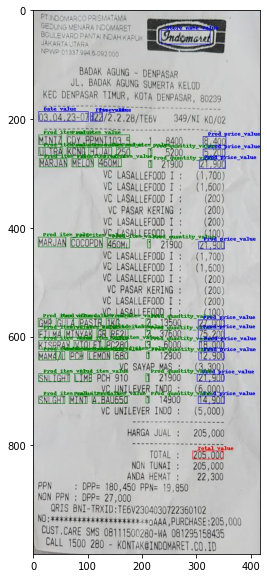

In [6]:
# filepath = os.path.join(DIR,'Nota_Segmented','Batch 2','20230210_093850.jpg')
# filepath = "Flask/android_img.jpg"
filepath = "C:/Users/asus/Desktop/test/tinggi/android_img_3-4-2023 '21.14.57.jpg"
filename = os.path.basename(filepath).split('.')[0]

image_result = get_receipt(filepath)
plt.figure(figsize=(10,10))
plt.imshow(image_result)
# img_for_BB = cv2.cvtColor(image_result, cv2.COLOR_BGR2GRAY)
# img_for_BB = cv2.adaptiveThreshold(img_for_BB,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# plt.figure(figsize=(10,10))
# plt.imshow(img_for_BB,cmap='gray')

print("getting : ",filepath)

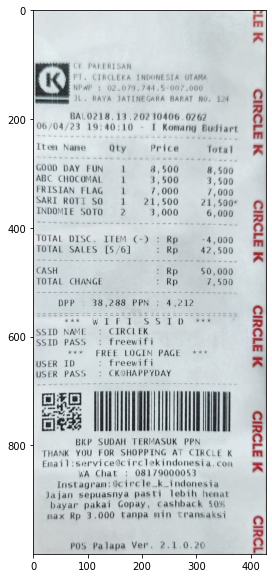

In [52]:
## contrast enchancement
lab= cv2.cvtColor(image_result, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(l_channel)
limg = cv2.merge((cl,a,b))
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
image_result = enhanced_img
plt.figure(figsize=(10,10))
plt.imshow(enhanced_img)

In [53]:
try:
    height, width, _ = image_result.shape
    res = ocr_agent.detect(image_result, return_response=True)
    texts  = ocr_agent.gather_text_annotations(res)
except:
    try:
        height, width = image_result.shape
        res = ocr_agent.detect(image_result, return_response=True)
        texts  = ocr_agent.gather_text_annotations(res)
    except:
        print("OCR failed")

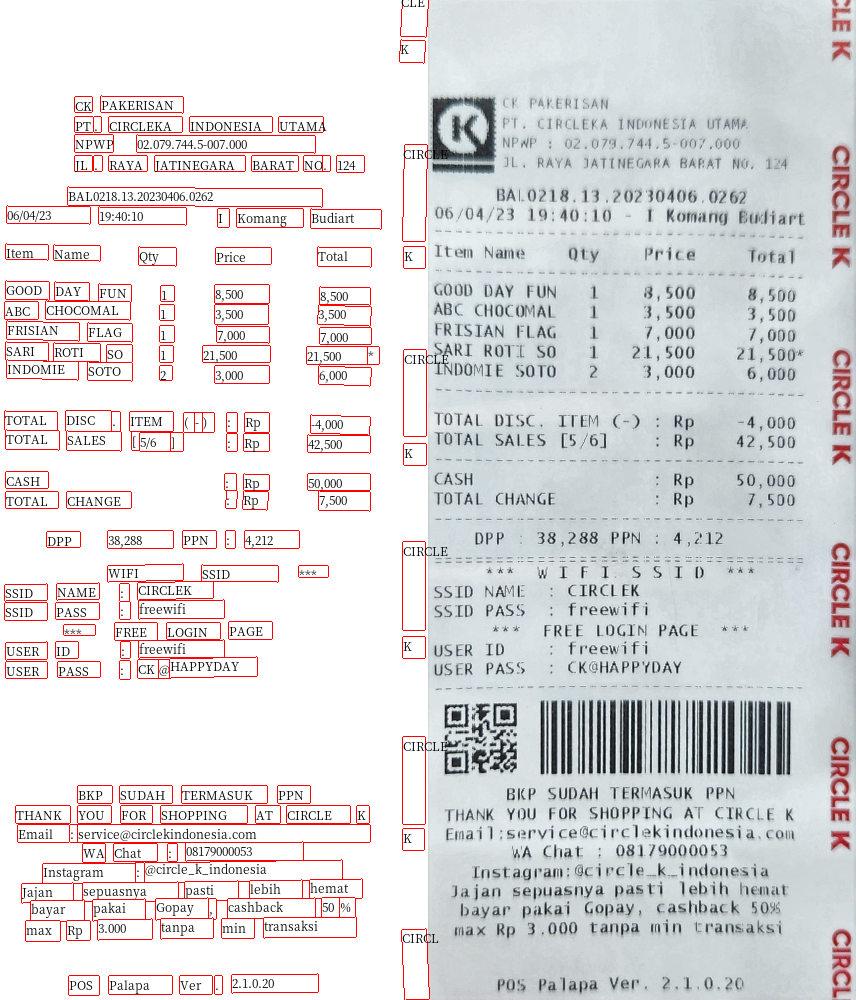

In [54]:
lp.draw_text(image_result, texts, font_size=12, with_box_on_text=True,
             text_box_width=3)

In [55]:

inference_words = []
for words_bbox in texts:
    inference_words.append(words_bbox.text)

inference_boxes = []
for words_bbox in texts:
    h = np.min(words_bbox.block.points, axis=0)
    w = np.max(words_bbox.block.points, axis=0)
    inference_boxes.append([h[0],h[1],w[0],w[1]])

for idx,boxes in enumerate(inference_boxes):
    if boxes[0] >= 1000 or boxes[1] >= 1000 or boxes[2] >= 1000 or boxes[3] >= 1000 or boxes[0] < 0 or boxes[1] < 0 or boxes[2] < 0 or boxes[3] < 0:
        print("boxes vefore :",boxes)
        if boxes[0] >= 1000:
            boxes[0] = 999
        if boxes[1] >= 1000:
            boxes[1] = 999
        if boxes[2] >= 1000:
            boxes[2] = 999
        if boxes[3] >= 1000:
            boxes[3] = 999
        if boxes[0] < 0:
            boxes[0] = 0
        if boxes[1] < 0:
            boxes[1] = 0
        if boxes[2] < 0:
            boxes[2] = 0
        if boxes[3] < 0:
            boxes[3] = 0
        new_boxes = boxes
        inference_boxes[idx] = new_boxes
        print(idx," boxes after :",new_boxes)
        

boxes vefore : [401, -7, 424, 33]
157  boxes after : [401, 0, 424, 33]


In [56]:
inf_img = Image.fromarray(image_result)
inf_words, inf_bboxes = inference_words, [normalize_box(box, (height, width)) for box in inference_boxes]

# encode
# encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
encoding = processor(inf_img, inf_words, boxes=inf_bboxes, return_tensors="pt",truncation=True,padding=True)

# forward pass
with torch.no_grad():
    outputs = model(**encoding)

# get predictions
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()
words_decoded = encoding["input_ids"].squeeze().tolist()


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [68]:
def BeautifyInfo(imginfo):
    newinfo = {}
    newinfo["Store"] = "".join(imginfo["Store"])
    if (len(newinfo["Store"]) > 0 and newinfo["Store"][0] == " "): # remove the first space
        newinfo["Store"] = newinfo["Store"][1:]
    newinfo["Date"] = "".join(imginfo["Date"])
    if (len(newinfo["Date"]) > 0 and newinfo["Date"][0] == " "): # remove the first space
        newinfo["Date"] = newinfo["Date"][1:]
    newinfo["Time"] = "".join(imginfo["Time"])
    if (len(newinfo["Time"]) > 0 and newinfo["Time"][0] == " "): # remove the first space
        newinfo["Time"] = newinfo["Time"][1:]
    try:
        newinfo["Total"] = "".join(list(imginfo["Total"].values())[0]['total'])
    except:
        newinfo["Total"] = "".join(imginfo["Total"])
    newinfo["Total"] = newinfo["Total"][1:]
    newinfo["Products"] = {}
    for idx,item in enumerate(imginfo["Products"].values()):
        newinfo["Products"][idx] = {}
        newinfo["Products"][idx]["name"] = "".join(item["name"])
        if len(newinfo["Products"][idx]["name"]) > 0 and newinfo["Products"][idx]["name"][0] == " ":
            newinfo["Products"][idx]["name"] = newinfo["Products"][idx]["name"][1:]
        newinfo["Products"][idx]["quantity"] = "".join(item["quantity"])
        if len(newinfo["Products"][idx]["quantity"]) > 0 and newinfo["Products"][idx]["quantity"][0] == " ":
            newinfo["Products"][idx]["quantity"] = newinfo["Products"][idx]["quantity"][1:]
        newinfo["Products"][idx]["price"] = "".join(item["price"])
        if len(newinfo["Products"][idx]["price"]) > 0 and newinfo["Products"][idx]["price"][0] == " ":
            newinfo["Products"][idx]["price"] = newinfo["Products"][idx]["price"][1:]

    datetime_regex = [
        r"^([0-9]{1,2})-([0-9]{1,2})-([0-9]{4})-([0-9]{1,2}:[0-9]{1,2})", # 01-01-2020-12:00 # ex Toosi
        r"^([0-9]{4})-([0-9]{1,2})-([0-9]{1,2})-([0-9]{1,2}:[0-9]{1,2})", # 2020-01-01-12:00
        r"^([0-9]{1,2})-([0-9]{1,2})-([0-9]{2})-([0-9]{1,2}:[0-9]{1,2})", # 01-01-20-12:00 CK
        r"([0-9]{1,2})-([0-9]{1,2})-([0-9]{2})-([0-9]{1,2}-:[0-9]{1,2})", # 01-01-20-12-:00 # ex indomaret
        r"([0-9]{1,2})-([0-9]{1,2})-([0-9]{2})-([0-9]{1,2}-[0-9]{1,2})" # 01-01-20-12-00 # ex KOVFEE
    ]
    datetime_str = newinfo['Date']+"-"+newinfo['Time']
    datetime_str = datetime_str.replace("/","-").replace(".","-").replace(" ","").replace(",","-").replace(".","-")

    ## beautify date and time
    print(datetime_str)
    for idx,regex in enumerate(datetime_regex):
        match = re.match(regex,datetime_str)
        if match:
            print("match with at index: ",idx)
            match_idx = idx
            break
        else:
            match_idx = -1

    if match_idx == 0:
        newinfo['Date'] = match.group(3)+"-"+match.group(2)+"-"+match.group(1)
        newinfo['Time'] = match.group(4)
    elif match_idx == 1:
        newinfo['Date'] = match.group(1)+"-"+match.group(2)+"-"+match.group(3)
        newinfo['Time'] = match.group(4)
    elif match_idx == 2:
        newinfo['Date'] = "20"+match.group(3)+"-"+match.group(2)+"-"+match.group(1)
        newinfo['Time'] = match.group(4)
    elif match_idx == 3:
        newinfo['Date'] = "20"+match.group(3)+"-"+match.group(2)+"-"+match.group(1)
        newinfo['Time'] = match.group(4).replace("-","")
    elif match_idx == 4:
        newinfo['Date'] = "20"+match.group(3)+"-"+match.group(2)+"-"+match.group(1)
        newinfo['Time'] = match.group(4).replace("-",":")
    else:
        print("No match found")
        print(datetime_str)
        try:
            newinfo['Date'] = newinfo['Date'].replace("/","-").replace(".","-").replace(" ","").replace(",","-").replace(".","-")
            while newinfo['Date'][-1] not in ["0","1","2","3","4","5","6","7","8","9"]:
                newinfo['Date'] = newinfo['Date'][:-1]
            newinfo['Time'] = newinfo['Time'].replace("/","-").replace(".","-").replace(" ","").replace(",","-").replace(".","-")
            while newinfo['Time'][-1] not in ["0","1","2","3","4","5","6","7","8","9"]:
                newinfo['Time'] = newinfo['Time'][:-1]
        except:
            pass


    return newinfo

def checkGreenFlag(imginfo):
    # additional check for the products
    green_flag = 0

    if "Products" in imginfo.keys():
        for prod_item in imginfo["Products"].values():
            red_flag = 0
            if len(prod_item["name"]) < 1:
                red_flag+=1
            if len(prod_item["price"]) < 1:
                red_flag+=1
            if len(prod_item["quantity"]) < 1:
                red_flag+=1
            # print("red :",red_flag)
            # means at least 1 product has parallel info of name, price and quantity
            if red_flag < 1:
                green_flag+=1
    else:
        for prod_item in imginfo.values():
            red_flag = 0
            if len(prod_item["name"]) < 1:
                red_flag+=1
            if len(prod_item["price"]) < 1:
                red_flag+=1
            if len(prod_item["quantity"]) < 1:
                red_flag+=1
            # print("red :",red_flag)
            # means at least 1 product has parallel info of name, price and quantity
            if red_flag < 1:
                green_flag+=1

    return green_flag

def reformatInfo(info):
    #products integer formatting
    products = {}

    leading2zero = r"(.+)(,[0-9]{2})$"

    for item in info['Products'].values():
        if len(item['name']) < 1 and len(item['price']) < 1 or len(item['name']) < 1 and len(item['quantity']) < 1:
            continue
        
        if len(item['price']) > 0:
            try:
                # remove leading 0
                match = re.match(leading2zero,item['price'])
                if match:
                    pricestr = match.group(1)
                else:
                    pricestr = item['price']

                pricestr = pricestr.replace(".","-").replace(",","-").replace(" ","/")
                price = []
                for it in pricestr.split('-'):
                    if len(it) > 0:
                        price.append(it)

                corrected_price = ""
                for idx,it in enumerate(price):
                    if idx != 0:
                        if len(it) == 3:
                            corrected_price += it
                    else:
                        corrected_price += it
                            
                if pricestr[0] == '-':
                    corrected_price = '-' + corrected_price
                    
                item['price'] = int(corrected_price)
            except:
                item['price'] = 0
        else:
            item['price'] = 0

        try:
            if len(item['quantity']) > 0:
                item['quantity'] = int(item['quantity'].replace(",",".").split('.')[0])
            else:
                item['quantity'] = 0
        except:
            item['quantity'] = 0

        products[len(products)] = item

    info['Products'] = products
    return info

def checkPredictedLabels(info,predicted_labels,box,words):
    # middle point of the y axis
    mid_y = int(box[1]+(box[3]-box[1]))

    box_tolerance = abs(int(box[3]-box[1])) # 10 pixels ? | auto tolerance
    # check if the box is already in the info dict with some tolerance
    if info["Products"].keys() is not None:
        if len(info["Products"].keys()) < 1:
            tolerated_box = mid_y

        # add tolerance to the y axis
        for key in info["Products"].keys():
            
            # adding for performance and easier debugging
            if mid_y == key:
                tolerated_box = mid_y
                break

            if mid_y < key+box_tolerance and mid_y > key-box_tolerance:
                # print("tolerating: ", mid_y , " to ", key)
                tolerated_box = key
                break
            else:
                # print("not allowing: ", mid_y , " to ", key)
                tolerated_box = mid_y
    else:
        tolerated_box = mid_y

    # check if the box is already in the info dict with some tolerance
    if info["Total"].keys() is not None:
        if len(info["Total"].keys()) < 1:
            tolerated_total = mid_y

        # add tolerance to the y axis
        for key in info["Total"].keys():
            
            # adding for performance and easier debugging
            if mid_y == key:
                tolerated_total = mid_y
                break

            if mid_y < key+box_tolerance and mid_y > key-box_tolerance:
                # print("tolerating: ", mid_y , " to ", key)
                tolerated_total = key
                break
            else:
                # print("not allowing: ", mid_y , " to ", key)
                tolerated_total = mid_y
    else:
        tolerated_total = mid_y
        
    # addes the words to the right key in the info dict
    if predicted_labels == 'Date_value':
        info["Date"].append(words)
    elif predicted_labels == 'Time_value':
        info["Time"].append(words)
    elif predicted_labels == 'Store_name_value':
        info["Store"].append(words)
    elif predicted_labels == 'Total_value':
        if tolerated_total not in info["Total"].keys():
            info["Total"][tolerated_total] = {"total":[]}
        info["Total"][tolerated_total]['total'].append(words)
    elif predicted_labels == 'Prod_item_value':
        if tolerated_box not in info["Products"].keys():
            info["Products"][tolerated_box] = {"name":[],"quantity":[],"price":[]}
        
        info["Products"][tolerated_box]["name"].append(words)
    elif predicted_labels == 'Prod_price_value':
        if tolerated_box not in info["Products"].keys():
            info["Products"][tolerated_box] = {"name":[],"quantity":[],"price":[]}
        
        info["Products"][tolerated_box]["price"].append(words)  
    elif predicted_labels == 'Prod_quantity_value':
        if tolerated_box not in info["Products"].keys():
            info["Products"][tolerated_box] = {"name":[],"quantity":[],"price":[]}
        info["Products"][tolerated_box]["quantity"].append(words)

In [58]:
# Generating Receipt Info
imginfo = {}
imginfo['Store'] = []
imginfo['Date'] = []
imginfo['Time'] = []
imginfo["Products"] = {}
imginfo['Total'] = {}

IMPORTANT_LABELS = ['Store_name_value',
                    'Date_value',
                    'Time_value',
                    'Prod_item_value',
                    'Prod_quantity_value',
                    'Prod_price_value',
                    'Total_value']

# only keep non-subword predictions
true_predictions = [id2label[pred] for idx, pred in enumerate(predictions)]
true_boxes = [unnormalize_box(box, (height, width)) for idx, box in enumerate(token_boxes)]

# draw predictions over the image
draw = ImageDraw.Draw(inf_img)
font = ImageFont.load_default()
for prediction, box, words in zip(true_predictions, true_boxes, words_decoded):
    predicted_label = prediction
    checkPredictedLabels(imginfo,predicted_label,box,processor.tokenizer.decode(words))
    # if predicted_label in IMPORTANT_LABELS:
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

# Save for future reference
inf_img.save(os.path.join(DIR,'serverfuction_1.jpg'))

# Beautify the info
beautyinfo = BeautifyInfo(imginfo)
mostGreenFlag = checkGreenFlag(beautyinfo)
mostTrueProducts = beautyinfo['Products'].copy()

# if there's a potential for incorrect layout
# meaning less than half of the products detected is false
# check for the other potential layout
# print("Original Layout")
# print(beautyinfo)
print(f"Most Green Flag: {mostGreenFlag}")
print(f"Products Length: {len(beautyinfo['Products'])//2}")

if (len(beautyinfo["Products"])//2) > mostGreenFlag:
    print("Trying other Layout")
    
    
    # 2nd method for getting products
    print("2nd method")
    tmpinfo = beautyinfo['Products'].copy()
    pop_idx = []
    for idx,prod_item in enumerate(tmpinfo.values()):
        # if its not the first item
        if idx > 0:
            # if it have no name but has price and quantity
            # print(f"if {len(prod_item['name'])} < 1 and {len(prod_item['quantity'])} > 1 and {len(prod_item['price'])} > 1:")
            if len(prod_item["name"]) < 1 and len(prod_item['quantity']) > 0 and len(prod_item['price']) > 0:
                # then the name is the previous item
                tmpinfo[idx]["name"] = tmpinfo[idx-1]["name"]
                pop_idx.append(idx-1)
    # remove the previous item
    for idx in pop_idx:
        tmpinfo.pop(idx)

    # check again
    if mostGreenFlag < checkGreenFlag(tmpinfo):
        print("2nd method is better")
        print(tmpinfo)
        mostTrueProducts = tmpinfo.copy()
        mostGreenFlag = checkGreenFlag(tmpinfo)

    # 3rd method for getting products
    print("3rd method")
    tmpinfo = beautyinfo['Products'].copy()
    pop_idx = []
    for idx,prod_item in enumerate(tmpinfo.values()):
        # if its not the first item
        if idx > 0:
            # if it has name but dont have price and quantity
            # print(f"if {len(prod_item['name'])} < 1 and {len(prod_item['quantity'])} > 1 and {len(prod_item['price'])} > 1:")
            if len(prod_item["name"]) > 0 and len(prod_item['quantity']) < 1 and len(prod_item['price']) < 1:
                if len(tmpinfo[idx-1]["name"]) < 1 and len(tmpinfo[idx-1]['quantity']) > 0 and len(tmpinfo[idx-1]['price']) > 0:
                    # then the price and quantity is the previous item
                    tmpinfo[idx]["quantity"] = tmpinfo[idx-1]["quantity"]
                    tmpinfo[idx]["price"] = tmpinfo[idx-1]["price"]
                    pop_idx.append(idx-1)
    # remove the previous item
    for idx in pop_idx:
        tmpinfo.pop(idx)

    # check again
    if mostGreenFlag < checkGreenFlag(tmpinfo):
        print("3rd method is better")
        print(tmpinfo)
        mostTrueProducts = tmpinfo.copy()
        mostGreenFlag = checkGreenFlag(tmpinfo)

    # 4th method for getting products
    print("4th method")
    tmpinfo = beautyinfo['Products'].copy()
    pop_idx = []
    for idx,prod_item in enumerate(tmpinfo.values()):
        # if its not the first item
        if idx > 0:
            # if it has quantity and but dont have name and price
            # print(f"if {len(prod_item['name'])} < 1 and {len(prod_item['quantity'])} > 1 and {len(prod_item['price'])} > 1:")
            if len(prod_item["name"]) < 1 and len(prod_item['quantity']) > 0 and len(prod_item['price']) < 1:
                if len(tmpinfo[idx-1]["name"]) > 0 and len(tmpinfo[idx-1]['quantity']) < 1 and len(tmpinfo[idx-1]['price']) > 0:
                    # then the name and price is the previous item
                    tmpinfo[idx]["name"] = tmpinfo[idx-1]["name"]
                    tmpinfo[idx]["price"] = tmpinfo[idx-1]["price"]
                    pop_idx.append(idx-1)
    # remove the previous item
    for idx in pop_idx:
        tmpinfo.pop(idx)

    # check again
    if mostGreenFlag < checkGreenFlag(tmpinfo):
        print("4th method is better")
        print(tmpinfo)
        mostTrueProducts = tmpinfo.copy()
        mostGreenFlag = checkGreenFlag(tmpinfo)

    beautyinfo["Products"] = mostTrueProducts

# if still no green flag then we can't say that the info is correct
if  mostGreenFlag < 1:
    #raise error
    print(beautyinfo)

# remove products that have 1 info only
pop_idx = []
for key,prod_item in beautyinfo["Products"].items():
    trueval = 0
    if len(prod_item["name"]) > 0:
        trueval += 1
    if len(prod_item['quantity']) > 0:
        trueval += 1
    if len(prod_item['price']) > 0:
        trueval += 1
    if trueval < 2:
        pop_idx.append(key)
for key in pop_idx:
    beautyinfo["Products"].pop(key)

Most Green Flag: 5
Products Length: 2


In [69]:
imginfo

{'Store': [],
 'Date': [' 06', '/', '04', '/', '23'],
 'Time': [' 19', ':', '40', ':', '10'],
 'Products': {296: {'name': [' GOOD', ' DAY', ' FUN'],
   'quantity': [' 1'],
   'price': [' 8', ',', '500']},
  315: {'name': [' ABC', ' CH', 'OC', 'OM', 'AL'],
   'quantity': [' 1'],
   'price': [' 3', ',', '500']},
  337: {'name': [' FR', 'IS', 'IAN', ' FL', 'AG'],
   'quantity': [' 1'],
   'price': [' 7', ',', '000']},
  357: {'name': [' S', 'ARI', ' R', 'OT', 'I', ' SO'],
   'quantity': [' 1'],
   'price': [' 21', ',', '500']},
  376: {'name': [' IND', 'OM', 'IE', ' S', 'OTO'],
   'quantity': [' 2'],
   'price': [' 6', ',', '000']}},
 'Total': {449: {'total': [' 42', ',']}}}

In [70]:
BeautifyInfo(imginfo)

06-04-23-19:40:10
match with at index:  2


{'Store': '',
 'Date': '2023-0406',
 'Time': '19:40',
 'Total': '42,',
 'Products': {0: {'name': 'GOOD DAY FUN', 'quantity': '1', 'price': '8,500'},
  1: {'name': 'ABC CHOCOMAL', 'quantity': '1', 'price': '3,500'},
  2: {'name': 'FRISIAN FLAG', 'quantity': '1', 'price': '7,000'},
  3: {'name': 'SARI ROTI SO', 'quantity': '1', 'price': '21,500'},
  4: {'name': 'INDOMIE SOTO', 'quantity': '2', 'price': '6,000'}}}

In [60]:
reformatInfo(beautyinfo)

{'Store': '',
 'Date': '23-04-2006',
 'Time': '19:40',
 'Total': '42,',
 'Products': {0: {'name': 'GOOD DAY FUN', 'quantity': 1, 'price': 8500},
  1: {'name': 'ABC CHOCOMAL', 'quantity': 1, 'price': 3500},
  2: {'name': 'FRISIAN FLAG', 'quantity': 1, 'price': 7000},
  3: {'name': 'SARI ROTI SO', 'quantity': 1, 'price': 21500},
  4: {'name': 'INDOMIE SOTO', 'quantity': 2, 'price': 6000}}}

In [51]:
prod = beautyinfo['Products']

for item in list(prod.values()):
    if len(item['price']) > 0:
        item['price'] = int(item['price'].replace(',','').replace('.',''))
    else:
        item['price'] = 0
    print(item['quantity'])
    if len(item['quantity']) > 0:
        print("got ",int(item['quantity'].split('.')[0]))
        item['quantity'] = int(item['quantity'].split('.')[0])
    else:
        item['quantity'] = 0
prod

1
got  1
1
got  1
1
got  1


{0: {'name': 'LARUTAN CAP', 'quantity': 1, 'price': 8000},
 1: {'name': 'FRISIAN FLAG', 'quantity': 1, 'price': 7500},
 2: {'name': 'PASEO TRAVEL', 'quantity': 1, 'price': 5500}}

In [53]:
beautyinfo['Total']

'21,000'

In [157]:
# json.dump(list(beautyinfo['Products'].values()), open(os.path.join(DIR,'Result',filename+'.json'), 'w'))

In [54]:
ab = "47,000"
print(ab)
ab = ab.replace(',','-').replace('.','-')
total = "".join(ab.split('-')[0])+ ab.split('-')[1][:3]
total = int(total)
total

47,000


47000

In [53]:
import datetime
from date_extractor import extract_dates
date_str = "01/apr/23/01/apr/23"
dateread = extract_dates(date_str)

ymd = {'year':0,'month':0,'day':0}
for it in dateread:
    print(it)

#     if(it.year > ymd['year']):
#         ymd['year'] = it.year
#     if(it.month > ymd['month']):
#         ymd['month'] = it.month
#     if(it.day > ymd['day']):
#         ymd['day'] = it.day

# new_str = f"{ymd['year']}-{ymd['month']:02d}-{ymd['day']:02d}"
# new_str

2023-04-01 00:00:00+00:00
2023-04-01 00:00:00+00:00


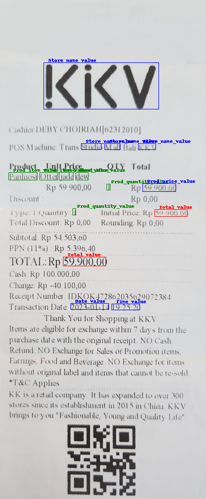

In [4]:
# inf_img = Image.open("Result/Android/android_img_5-3-2023 '6.11.8.jpg")
# img_byte_arr = io.BytesIO()
# inf_img.save(img_byte_arr, format='PNG')
# img_byte_arr = img_byte_arr.getvalue()
# zzz = base64.b64encode(img_byte_arr).decode('utf-8')

### decode
with open("Result/imgtest/test.txt", "r") as text_file:
    image_str = text_file.read()
byteImgIO = io.BytesIO()
data = base64.b64decode(image_str)
byteImgIO.write(data)
byteImgIO.seek(0)
byteImg = Image.open(byteImgIO)
byteImg

In [9]:
import re
leading2zero = r"(.+)(,[0-9]{2})$"
zz = "-10.000,00"
# remove leading 0
match = re.match(leading2zero,zz)
if match:
    pricestr = match.group(1)
else:
    pricestr = zz

pricestr = pricestr.replace(".","-").replace(",","-").replace(" ","/")
price = []
for it in pricestr.split('-'):
    if len(it) > 0:
        price.append(it)
corrected_price = ""
for idx,it in enumerate(price):
    if idx != 0:
        if len(it) == 3:
            corrected_price += it
    else:
        corrected_price += it
if pricestr[0] == '-':
    corrected_price = '-' + corrected_price
corrected_price

'-10000'

In [7]:
a = {1: {'name': 'Panluosi Otter jade dew', 'quantity': '1', 'price': '59.900,00'}, 2: {'name': '', 'quantity': '1', 'price': ''}}
for item in a.values():
    print(item['name'])

Panluosi Otter jade dew



In [5]:
text = "-5500"
int(text)

-5500